# Dfs0

See [Dfs0 in MIKE IO Documentation](https://dhi.github.io/mikeio/user-guide/dfs0.html)


In [1]:
import pandas as pd
import mikeio

## Reading data

In [2]:
ds = mikeio.read("data/Oresund_ts.dfs0")
ds

<mikeio.Dataset>
dims: (time:2017)
time: 2018-03-04 00:00:00 - 2018-03-11 00:00:00 (2017 records)
geometry: GeometryUndefined()
number of items: 12

In [3]:
type(ds)

mikeio.dataset._dataset.Dataset

The mikeio read function returns a `Dataset` which is a container of `DataArray`s.

A `DataArray` can be selected by name or by index.

In [4]:
da = ds["Drogden: Surface elevation"]   # or ds.Drogden_Surface_elevation or ds[2]
da

<mikeio.DataArray>
name: Drogden: Surface elevation
dims: (time:2017)
time: 2018-03-04 00:00:00 - 2018-03-11 00:00:00 (2017 records)
geometry: GeometryUndefined()
values: [0.05063, 0.04713, ..., 0.2404]

Upon `read`, specific items can be selected with the `items` argument using name or index.

In [5]:
ds = mikeio.read("data/Oresund_ts.dfs0", items=[0,2,3])
ds

<mikeio.Dataset>
dims: (time:2017)
time: 2018-03-04 00:00:00 - 2018-03-11 00:00:00 (2017 records)
geometry: GeometryUndefined()
items:
  0:  Viken: Surface elevation <Surface Elevation> (meter)
  1:  Drogden: Surface elevation <Surface Elevation> (meter)
  2:  Klagshamn: Surface elevation <Surface Elevation> (meter)

Wildcards can be used to select multiple items:

In [6]:
ds = mikeio.read("data/Oresund_ts.dfs0", items="*Surf*")
ds

<mikeio.Dataset>
dims: (time:2017)
time: 2018-03-04 00:00:00 - 2018-03-11 00:00:00 (2017 records)
geometry: GeometryUndefined()
items:
  0:  Viken: Surface elevation <Surface Elevation> (meter)
  1:  Hornbæk: Surface elevation <Surface Elevation> (meter)
  2:  Drogden: Surface elevation <Surface Elevation> (meter)
  3:  Klagshamn: Surface elevation <Surface Elevation> (meter)

A specific time subset can be selected by index (or sel method) or already upon read: 

In [7]:
ds["2018-03-04"]  # or ds.sel(time="2018-03-04")

<mikeio.Dataset>
dims: (time:288)
time: 2018-03-04 00:00:00 - 2018-03-04 23:55:00 (288 records)
geometry: GeometryUndefined()
items:
  0:  Viken: Surface elevation <Surface Elevation> (meter)
  1:  Hornbæk: Surface elevation <Surface Elevation> (meter)
  2:  Drogden: Surface elevation <Surface Elevation> (meter)
  3:  Klagshamn: Surface elevation <Surface Elevation> (meter)

In [8]:
ds = mikeio.read("data/Oresund_ts.dfs0", items="*Surf*", time="2018-03-04")
ds

<mikeio.Dataset>
dims: (time:288)
time: 2018-03-04 00:00:00 - 2018-03-04 23:55:00 (288 records)
geometry: GeometryUndefined()
items:
  0:  Viken: Surface elevation <Surface Elevation> (meter)
  1:  Hornbæk: Surface elevation <Surface Elevation> (meter)
  2:  Drogden: Surface elevation <Surface Elevation> (meter)
  3:  Klagshamn: Surface elevation <Surface Elevation> (meter)

The Dataset and DataArray have a number of useful attributes like `time`, `items`, `ndims`, `shape`, `values` (only DataArray) etc

In [9]:
ds.time

DatetimeIndex(['2018-03-04 00:00:00', '2018-03-04 00:05:00',
               '2018-03-04 00:10:00', '2018-03-04 00:15:00',
               '2018-03-04 00:20:00', '2018-03-04 00:25:00',
               '2018-03-04 00:30:00', '2018-03-04 00:35:00',
               '2018-03-04 00:40:00', '2018-03-04 00:45:00',
               ...
               '2018-03-04 23:10:00', '2018-03-04 23:15:00',
               '2018-03-04 23:20:00', '2018-03-04 23:25:00',
               '2018-03-04 23:30:00', '2018-03-04 23:35:00',
               '2018-03-04 23:40:00', '2018-03-04 23:45:00',
               '2018-03-04 23:50:00', '2018-03-04 23:55:00'],
              dtype='datetime64[ns]', length=288, freq=None)

In [10]:
ds.items

[Viken: Surface elevation <Surface Elevation> (meter),
 Hornbæk: Surface elevation <Surface Elevation> (meter),
 Drogden: Surface elevation <Surface Elevation> (meter),
 Klagshamn: Surface elevation <Surface Elevation> (meter)]

In [11]:
da.item

Drogden: Surface elevation <Surface Elevation> (meter)

In [12]:
da.shape

(2017,)

In [13]:
da.values

array([0.05062908, 0.04713159, 0.04382962, ..., 0.23521478, 0.23782268,
       0.24038477])

The time series can be plotted with the plot method.

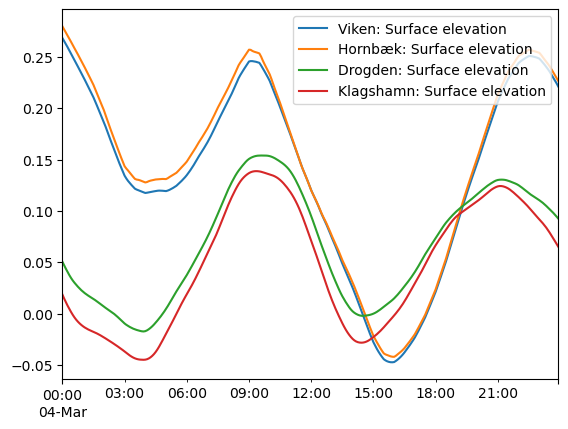

In [14]:
ds.plot();

A simple timeseries Dataset can easily be converted to a Pandas DataFrame.

In [15]:
df = ds.to_pandas() # convert dataset to dataframe
df

,Viken: Surface elevation,Hornbæk: Surface elevation,Drogden: Surface elevation,Klagshamn: Surface elevation
2018-03-04 00:00:00,0.268416,0.279761,0.050629,0.018723
2018-03-04 00:05:00,0.265478,0.276792,0.047132,0.014833
2018-03-04 00:10:00,0.262521,0.273909,0.043830,0.011230
2018-03-04 00:15:00,0.259481,0.270935,0.040655,0.007876
2018-03-04 00:20:00,0.256348,0.267858,0.037621,0.004712
...,...,...,...,...
2018-03-04 23:35:00,0.232721,0.237954,0.099927,0.076122
2018-03-04 23:40:00,0.229933,0.235055,0.098214,0.073399
2018-03-04 23:45:00,0.227105,0.232199,0.096391,0.070642
2018-03-04 23:50:00,0.224168,0.229341,0.094460,0.067864


## Writing data

Often, time series data will come from a csv or an Excel file. Here is an example of how to read a csv file with pandas and then write the pandas DataFrame to a dfs0 file.

In [16]:
df = pd.read_csv("data/naples_fl.csv", skiprows=1, parse_dates=True, index_col=0)
df

,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
Date,,,,,,
2002-03-01,67.0,78.0,56.0,0.00,NaN,NaN
2002-03-02,76.0,83.0,69.0,0.00,NaN,NaN
2002-03-03,78.0,84.0,71.0,0.00,NaN,NaN
2002-03-04,64.0,76.0,51.0,0.08,NaN,NaN
2002-03-05,58.0,70.0,45.0,0.00,NaN,NaN
...,...,...,...,...,...,...
2021-08-11,NaN,93.0,77.0,0.23,NaN,NaN
2021-08-12,NaN,94.0,77.0,0.00,0.0,0.0
2021-08-13,NaN,95.0,77.0,0.03,0.0,0.0


You will probably have the need to parse certain a specific data formats many times, then it is a good idea to create a function.

In [17]:
def read_ncei_obs(filename):
    # old name : new name
    mapping = {'TAVG (Degrees Fahrenheit)': 'temperature_avg_f',
               'TMAX (Degrees Fahrenheit)': 'temperature_max_f',
               'TMIN (Degrees Fahrenheit)': 'temperature_min_f',
               'PRCP (Inches)': 'prec_in'}
    
    sel_cols = mapping.values() # No need to repeat ['temperature_avg_f',...]
    df = (
        pd.read_csv(filename, skiprows=1, parse_dates=True, index_col=0)
           .rename(columns=mapping)
    )[sel_cols]
    return df

In [18]:
df = read_ncei_obs("data/naples_fl.csv")
df.head()

,temperature_avg_f,temperature_max_f,temperature_min_f,prec_in
Date,,,,
2002-03-01,67.0,78.0,56.0,0.00
2002-03-02,76.0,83.0,69.0,0.00
2002-03-03,78.0,84.0,71.0,0.00
2002-03-04,64.0,76.0,51.0,0.08
2002-03-05,58.0,70.0,45.0,0.00


In [19]:
df.tail()

,temperature_avg_f,temperature_max_f,temperature_min_f,prec_in
Date,,,,
2021-08-11,NaN,93.0,77.0,0.23
2021-08-12,NaN,94.0,77.0,0.00
2021-08-13,NaN,95.0,77.0,0.03
2021-08-14,NaN,85.0,74.0,0.05
2021-08-15,NaN,83.0,75.0,0.01


In [20]:
df.shape

(7108, 4)

Convert temperature to Celsius and precipitation to mm.

In [21]:
df_final = df.assign(temperature_max_c=(df['temperature_max_f'] - 32)/1.8,
                 prec_mm=df['prec_in'] * 25.4)

df_final.head()

,temperature_avg_f,temperature_max_f,temperature_min_f,prec_in,temperature_max_c,prec_mm
Date,,,,,,
2002-03-01,67.0,78.0,56.0,0.00,25.555556,0.000
2002-03-02,76.0,83.0,69.0,0.00,28.333333,0.000
2002-03-03,78.0,84.0,71.0,0.00,28.888889,0.000
2002-03-04,64.0,76.0,51.0,0.08,24.444444,2.032
2002-03-05,58.0,70.0,45.0,0.00,21.111111,0.000


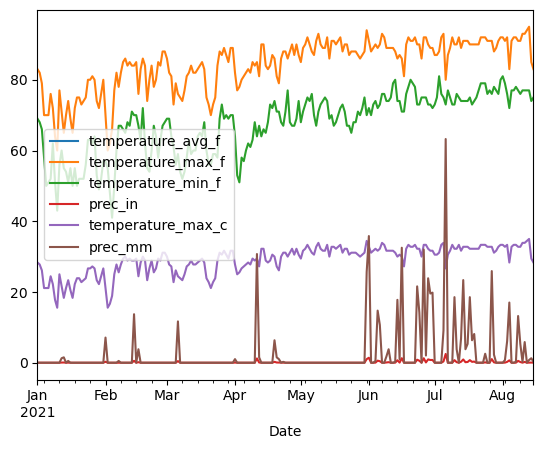

In [22]:
df_final.loc['2021'].plot();

Creating a dfs0 file from a dataframe is pretty straightforward.

1. Convert the dataframe to a `Dataset`

In [23]:
ds = mikeio.from_pandas(df_final)
ds

<mikeio.Dataset>
dims: (time:7108)
time: 2002-03-01 00:00:00 - 2021-08-15 00:00:00 (7108 records)
geometry: GeometryUndefined()
items:
  0:  temperature_avg_f <Undefined> (undefined)
  1:  temperature_max_f <Undefined> (undefined)
  2:  temperature_min_f <Undefined> (undefined)
  3:  prec_in <Undefined> (undefined)
  4:  temperature_max_c <Undefined> (undefined)
  5:  prec_mm <Undefined> (undefined)

2. Write the `Dataset` to a dfs0 file.

In [24]:
ds.to_dfs("output/naples_fl.dfs0")

Let's read it back in again...

In [25]:
saved_ds = mikeio.read("output/naples_fl.dfs0")
saved_ds

<mikeio.Dataset>
dims: (time:7108)
time: 2002-03-01 00:00:00 - 2021-08-15 00:00:00 (7108 records)
geometry: GeometryUndefined()
items:
  0:  temperature_avg_f <Undefined> (undefined)
  1:  temperature_max_f <Undefined> (undefined)
  2:  temperature_min_f <Undefined> (undefined)
  3:  prec_in <Undefined> (undefined)
  4:  temperature_max_c <Undefined> (undefined)
  5:  prec_mm <Undefined> (undefined)

By default, EUM types are undefined. But it can be specified. Let's select a few colums.

In [26]:
df2 = df_final[['temperature_max_c', 'prec_in']]
df2.head()

,temperature_max_c,prec_in
Date,,
2002-03-01,25.555556,0.00
2002-03-02,28.333333,0.00
2002-03-03,28.888889,0.00
2002-03-04,24.444444,0.08
2002-03-05,21.111111,0.00


In [27]:
from mikeio import ItemInfo, EUMType, EUMUnit

ds2 = mikeio.from_pandas(df2, 
                         items=[
                   ItemInfo(EUMType.Temperature),
                   ItemInfo(EUMType.Precipitation_Rate, EUMUnit.inch_per_day)]
           )
ds2

<mikeio.Dataset>
dims: (time:7108)
time: 2002-03-01 00:00:00 - 2021-08-15 00:00:00 (7108 records)
geometry: GeometryUndefined()
items:
  0:  temperature_max_c <Temperature> (degree Celsius)
  1:  prec_in <Precipitation Rate> (inch per day)

## EUM

In [28]:
from mikeio.eum import ItemInfo, EUMType, EUMUnit

EUMType.search("wind")


[Wind Velocity,
 Wind Direction,
 Wind friction factor,
 Wind speed,
 Depth of Wind,
 Wind friction speed]

In [29]:
EUMType.Wind_speed.units

[meter per sec, feet per sec, knot, km per hour, miles per hour]

### Inline Exercise

What is the best EUM Type for "peak wave direction"? What is the default unit? 

In [30]:
# insert your code here

## Precipitation data

In [31]:
df = pd.read_csv("data/precipitation.csv", parse_dates=True, index_col=0)
df.head()

,Precipitation station 1,Precipitation station 2,Precipitation station 3,Precipitation station 4,Precipitation station 5,Precipitation station 6,Precipitation station 7,Precipitation station 8,Precipitation station 9
date,,,,,,,,,
2001-01-01,0.0,0.000,0.021,0.071,0.000,0.000,0.025,0.025,0.000
2001-01-02,0.0,0.025,0.037,0.000,0.004,0.054,0.042,0.021,0.054
2001-01-03,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.042,0.000
2001-01-04,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001-01-05,0.0,0.000,0.158,0.021,0.000,0.000,0.017,0.021,0.000


In [32]:
from mikecore.DfsFile import DataValueType

(mikeio.from_pandas(df, items=ItemInfo(EUMType.Precipitation_Rate, EUMUnit.mm_per_hour, data_value_type=DataValueType.MeanStepBackward))
        .to_dfs("output/precipitation.dfs0")
)


## Selecting 

In [33]:
ds = mikeio.read("output/precipitation.dfs0", items=[1,4]) # select item by item number (starting from zero)
ds

<mikeio.Dataset>
dims: (time:31)
time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00 (31 records)
geometry: GeometryUndefined()
items:
  0:  Precipitation station 2 <Precipitation Rate> (mm per hour) - 3
  1:  Precipitation station 5 <Precipitation Rate> (mm per hour) - 3

In [34]:
ds = mikeio.read("output/precipitation.dfs0", items=["Precipitation station 5","Precipitation station 1"]) # or by name (in the order you like it)
ds

<mikeio.Dataset>
dims: (time:31)
time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00 (31 records)
geometry: GeometryUndefined()
items:
  0:  Precipitation station 5 <Precipitation Rate> (mm per hour) - 3
  1:  Precipitation station 1 <Precipitation Rate> (mm per hour) - 3

### Inline Exercise

Read all items to a variable ds. Select "Precipitation station 3" - which different ways can you select this item?  

In [35]:
# insert your code here

In [36]:
import utils

utils.sysinfo()


    System: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]
    NumPy: 1.24.4
    Pandas: 2.1.3
    MIKE IO: 2.1.0
    Last modified: 2024-09-04 15:27:13.530239
    
